In [120]:
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
from imutils.object_detection import non_max_suppression
import imutils

In [113]:
img = Image.open('test_images/1.png').convert('RGB')
cvimage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

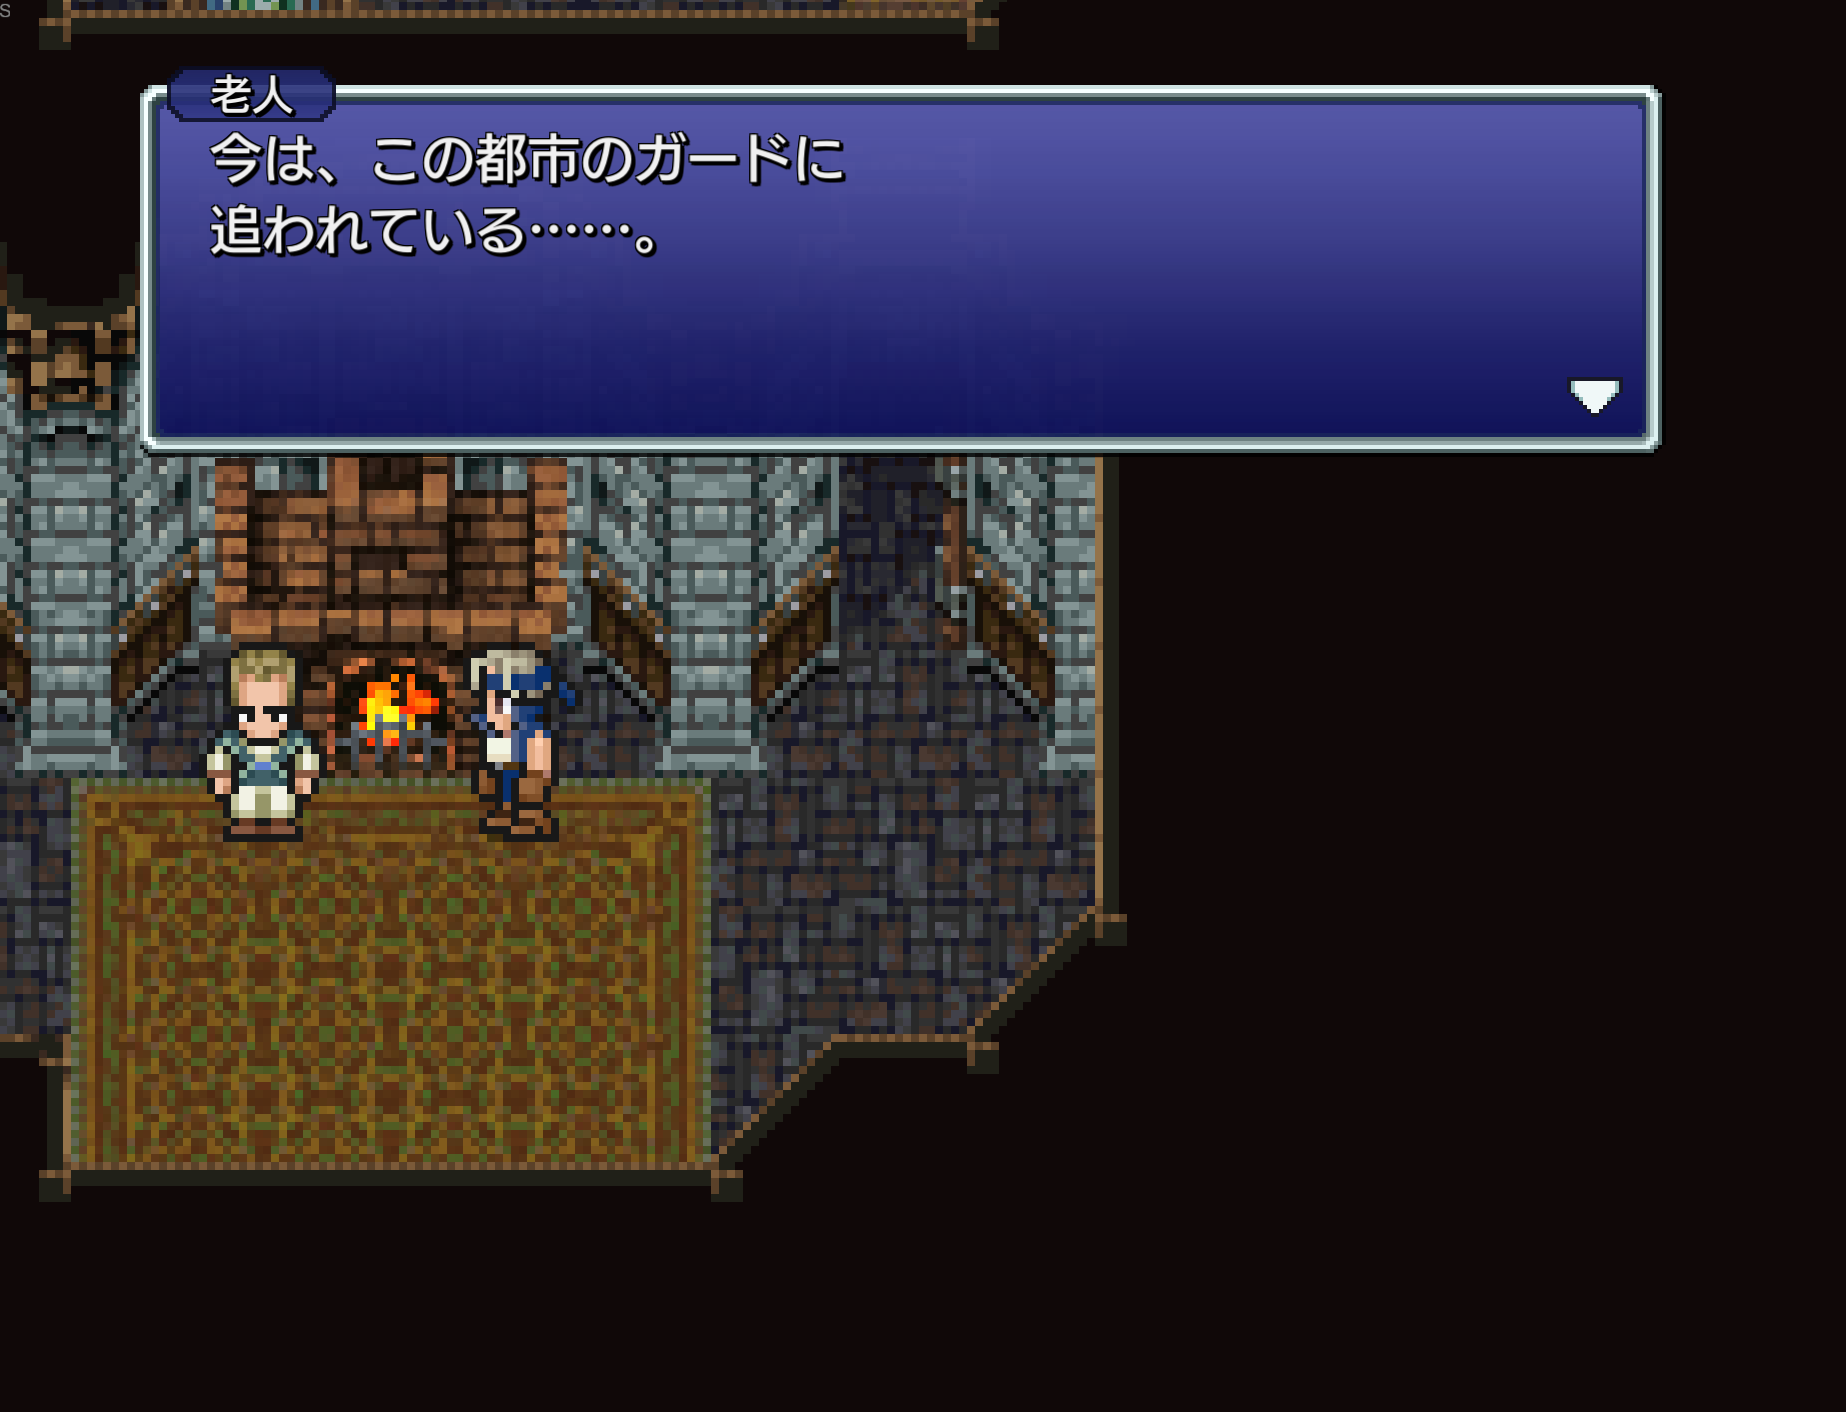

In [114]:
img

In [115]:
import cv2

In [116]:
net = cv2.dnn.readNet("model/frozen_east_text_detection.pb")

(1, 1, 256, 256)


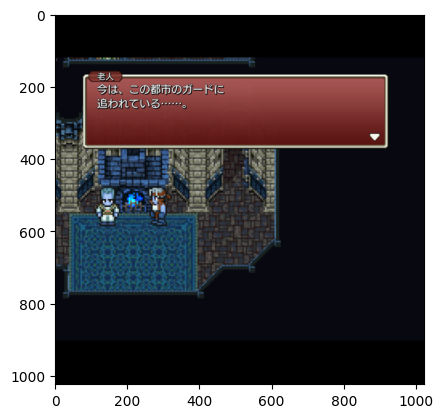

In [117]:
#resize the input image
#convert the original to square
def make_square(img, width):
    scale_factor = width/max(img.shape[:2])
    resized_image = cv2.resize(cvimage, (0,0), fx=scale_factor, fy=scale_factor, interpolation = cv2.INTER_AREA)
    top = bottom = (width - resized_image.shape[0])//2
    left = right = (width - resized_image.shape[1]) //2
    resized_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return resized_image

orig_width = min(cvimage.shape[:2])
image = make_square(cvimage, orig_width)
dswidth = 1024
rWdith = orig_width/dswidth

dsimage = cv2.resize(image, (dswidth, dswidth))

plt.imshow(dsimage)

blob = cv2.dnn.blobFromImage(image,1.0, (dswidth,dswidth), (123.68, 116.78, 103.94),crop=True)
net.setInput(blob)
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

(scores, geometry) = net.forward(layerNames)
print(scores.shape)

https://github.com/YCICI/EAST-OpenCv/blob/master/text_detection.py

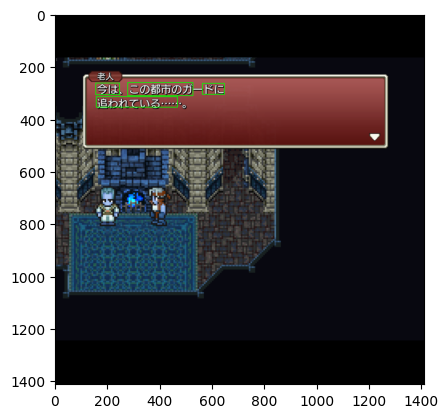

In [118]:
rects = []
confidences = []
orig = image.copy()

def extract_boundingbox(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
    
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            # Set minimum confidence as required
            if scoresData[x] < 0.3:
                continue
            # compute the offset factor as our resulting feature maps will
            #  x smaller than the input image
            # the output score is always 1/4 of the original image size
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    return boxes

boxes = extract_boundingbox(scores, geometry)
                    
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rWdith)
    startY = int(startY * rWdith)
    endX = int(endX * rWdith)
    endY = int(endY * rWdith)
    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
plt.imshow(orig)
